<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-7-TiernanScullyISE/blob/main/challenge-7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #7: Interpretability and explainable ML

In this assignment, you will explore explainability using LIME on image classification. Your tasks are:

1. **get_lime_explanation: (3 points)**  
   Given a pretrained image classifier and an input image, generate a LIME explanation object.

2. **display_lime_explanation: (1 point)**  
   From the explanation object, extract and return a visualization (image and mask overlay) that highlights important superpixels.

3. **extract_feature_importance: (1 point)**  
   Extract a list of important feature (superpixel) contributions from the explanation object, sorted by importance.

4. **Task 4:** Apply a pretrained ResNet model on an input image and use LIME to generate and display explanations for the top 5 predicted classes.

After coding, answer three brief reflection questions on explainability methods.

*Total points: 9 (6 points for code tasks and 3 points for reflection questions).*

---

## Background on LIME

LIME (Local Interpretable Model-agnostic Explanations) is a popular method for explaining predictions of any classifier. For image classification, LIME works by:
- Perturbing the input image by turning superpixels on/off.
- Evaluating how these perturbations affect the prediction.
- Fitting a local, interpretable linear model to approximate the classifier's behavior near the instance.

The result is an explanation object that can produce:
- A list of feature contributions.
- A visualization (image with a mask overlay) highlighting which superpixels had the greatest influence on the prediction.

**Additional resources:**  
[Official LIME blog post](https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/)  
[Tutorial notebooks on their official GitHub repository](https://github.com/marcotcr/lime/tree/master/doc/notebooks)  
[General article reading about explainable machine learning | Medium](https://medium.com/michelle-and-ryan-explain-ml/explainable-and-interpretable-machine-learning-7e7c28bba4f2)

## Imports & Setup

In [16]:
!pip install lime

In [17]:
from lime import lime_image
import torch
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import cv2
import json
from torchvision import models

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


## Task 1: Get LIME Explanation <font color='green'>(3 points)</font>

Generate and return a LIME explanation object for the given image and model.

In [18]:
def get_lime_explanation(model: torch.nn.Module, image: np.ndarray, top_labels: int = 5, num_samples: int = 1000):
    """
    Generate and return a LIME explanation object for the given image and model.

    Parameters:
        model (torch.nn.Module): A pretrained image classification model.
        image (np.ndarray): Input image in numpy array format (H x W x C).
        top_labels (int): Number of top labels to consider.
        num_samples (int): Number of perturbed samples to generate.

    Returns:
        explanation: A LIME explanation object (as returned by lime_image.LimeImageExplainer.explain_instance).
    """
    # Create an instance of LimeImageExplainer.
    explainer = lime_image.LimeImageExplainer()

    # Define a transformation to convert a numpy image to a torch tensor.
    # Extend this transform (e.g. add normalisation) as required by your model.
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts H x W x C in [0, 255] to C x H x W in [0.0, 1.0]
        # For example, add normalisation if needed:
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    def predict(images: np.ndarray):
        """
        Convert a batch of images to torch tensors, preprocess them,
        and return the model's prediction probabilities.

        Parameters:
            images (np.ndarray): Batch of images as numpy arrays (N, H, W, C).

        Returns:
            probabilities (np.ndarray): Prediction probabilities with shape (N, num_classes).
        """
        batch = []
        for img in images:
            # Apply the transformation to each image.
            # Resize the image to (224, 224) before converting to tensor
            img = cv2.resize(img, (224, 224))  # Resize to the expected input size of the model
            tensor_img = transform(img)
            batch.append(tensor_img)
        # Stack into a single tensor (N, C, H, W).
        batch_tensor = torch.stack(batch)

        # Ensure the model is in evaluation mode and perform inference without tracking gradients.
        model.eval()
        with torch.no_grad():
            outputs = model(batch_tensor)
            # Convert logits to probabilities using softmax.
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        return probabilities

    # Generate an explanation for the image using the prediction function.
    explanation = explainer.explain_instance(
        image,          # Original image as a numpy array.
        predict,        # Prediction function.
        top_labels=top_labels,
        num_samples=num_samples  # Number of perturbed samples.
    )

    return explanation

## Task 2: Display LIME Explanation <font color='green'>(1 point)</font>

Implement a function that extracts and returns the visualization of the LIME explanation. This function should use the explanation object's method (such as `get_image_and_mask`) to generate an image with an overlay mask that highlights the most important superpixels.

The output should be a tuple: (explanation_image, mask), which you can then display using matplotlib.

In [19]:
def display_lime_explanation(explanation, image: np.ndarray, positive_only: bool = True, num_features: int = 5):
    """
    From the LIME explanation object, generate and return the visualisation image and mask overlay.

    Parameters:
        explanation: The LIME explanation object.
        image (np.ndarray): The original image (H x W x C).
        positive_only (bool): Whether to show only features that positively influence the prediction.
        num_features (int): Number of superpixels to display.

    Returns:
        tuple: (explanation_image, mask) as produced by explanation.get_image_and_mask.
    """
    # Use the top predicted label from the explanation.
    label = explanation.top_labels[0]

    # Generate the explanation image and mask overlay.
    explanation_image, mask = explanation.get_image_and_mask(
        label,
        positive_only=positive_only,
        num_features=num_features,
        hide_rest=False  # You can set this to True if you want to hide all other regions.
    )

    return explanation_image, mask


## Task 3: Extract Feature Importance <font color='green'>(1 point)</font>

Implement a function that extracts a sorted list of feature (superpixel) contributions from the LIME explanation object. The function should return a list of tuples (feature_index, importance) sorted in descending order by importance.

In [20]:
def extract_feature_importance(explanation) -> list:
    """
    Extract and return a sorted list of feature contributions from the LIME explanation object.

    Returns:
        List[tuple]: Each tuple contains (feature_index, importance) sorted by importance (descending).
    """
    # Assume that we use the explanation for the top predicted label.
    top_label = explanation.top_labels[0]

    # Extract feature contributions for the top label.
    # Each tuple in local_exp is of the form (feature_index, weight).
    feature_importances = explanation.local_exp[top_label]

    # Sort features by the absolute magnitude of their contribution (importance) in descending order.
    feature_importances = sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True)

    return feature_importances


## Task 4: Top 5 explanations from a pretrained ResNet model <font color='green'>(2 points)</font>

Use a pretrained ResNet model to predict the image classes and generate LIME explanations for the top 5 classes.

In [21]:
# Download ImageNet class label mappings
!wget https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/imagenet_class_index.json?raw=true -O imagenet_class_index.json

--2025-03-07 11:21:05--  https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/imagenet_class_index.json?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/marcotcr/lime/raw/refs/heads/master/doc/notebooks/data/imagenet_class_index.json [following]
--2025-03-07 11:21:05--  https://github.com/marcotcr/lime/raw/refs/heads/master/doc/notebooks/data/imagenet_class_index.json
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcotcr/lime/refs/heads/master/doc/notebooks/data/imagenet_class_index.json [following]
--2025-03-07 11:21:06--  https://raw.githubusercontent.com/marcotcr/lime/refs/heads/master/doc/notebooks/data/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.1

In [22]:
def get_resnet_lime_explanations(image: np.ndarray):
    """
    Use a pretrained ResNet model to predict the image classes and generate LIME explanations for the top 5 classes.

    This function should:
      1. Load a pretrained ResNet (e.g., ResNet18) from torchvision.
      2. Apply necessary preprocessing to the image.
      3. Obtain predictions and determine the top 5 classes.
      4. For each of the top 5 classes, generate a LIME explanation using get_lime_explanation().
      5. Return a dictionary mapping each top class label to its corresponding explanation visualisation (image and mask).

    Boilerplate (e.g., label list) is provided below.

    Returns:
        dict: {class_label: (explanation_image, mask), ...} for top 5 classes.
    """
    # Predefined label list for demonstration (ImageNet class index).
    imagenet_labels = json.load(open("imagenet_class_index.json"))
    imagenet_labels = {int(key): value[1] for key, value in imagenet_labels.items()}

    # Load a pretrained ResNet18 model and set it to evaluation mode.
    model = models.resnet18(pretrained=True)
    model.eval()

    # Apply necessary preprocessing to the image: resize to 224x224.
    processed_image = cv2.resize(image, (224, 224))

    # Generate a LIME explanation for the image with top_labels=5.
    # (get_lime_explanation is assumed to be defined elsewhere.)
    explanation = get_lime_explanation(model, processed_image, top_labels=5, num_samples=1000)

    explanations = {}

    # Extract the top 5 labels from the explanation.
    top5_labels = explanation.top_labels

    # For each top label, extract its corresponding visualisation (image and mask).
    for label in top5_labels:
        class_name = imagenet_labels.get(label, str(label))
        expl_img, mask = explanation.get_image_and_mask(
            label,
            positive_only=True,
            num_features=5,
            hide_rest=False  # Set to True if you wish to hide all non-important regions.
        )
        explanations[class_name] = (expl_img, mask)

    return explanations


## Reflection Questions (answer in brief)  <font color='green'>(1 point each)</font>

**Question 1:**  
What are the main advantages of using LIME for explaining image classification models?  
*Your Answer:*  

> *(LIME is advantageous because it is model-agnostic, meaning it can explain any image classification model without requiring internal access. It provides local, interpretable explanations by highlighting key superpixels that contribute to a prediction, making the model’s decision process more transparent and easier to debug.)*

**Question 2:**  
How does LIME generate local explanations for a model's prediction, and why is this approach considered model-agnostic?  
*Your Answer:*  

> *(LIME generates local explanations by perturbing the input image to create a set of similar instances, then obtaining the model's predictions for these perturbed samples. It fits a simple, interpretable model—often linear—to this neighbourhood, which approximates the model's behaviour locally. This approach is considered model-agnostic because it treats the model as a black box, requiring only the prediction outputs rather than any internal details or gradients.)*

**Question 3:**  
Discuss the trade-offs between model complexity and interpretability. How do these trade-offs impact both the performance of a model and its deployment in real-world, sensitive applications?
*Your Answer:*

*(Complex models (like deep neural networks) usually deliver high accuracy but are opaque, requiring post-hoc methods to interpret. Simpler models offer clear, transparent decision-making, which is crucial in sensitive applications, though they may not capture complex patterns as effectively.)*

---
### Autograder

Run this code cell at the end and do not change any code here.

mkdir: cannot create directory ‘datasets’: File exists
will be placed in the single file you specified.

--2025-03-07 11:24:09--  https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/main/datasets/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47018 (46K) [image/jpeg]
Saving to: ‘datasets/dog.jpg’

datasets/dog.jpg    100%[===================>]  45.92K  --.-KB/s    in 0.002s  

2025-03-07 11:24:09 (20.0 MB/s) - ‘datasets/dog.jpg’ saved [47018/47018]

FINISHED --2025-03-07 11:24:09--
Total wall clock time: 0.4s
Downloaded: 1 files, 46K in 0.002s (20.0 MB/s)


  0%|          | 0/100 [00:00<?, ?it/s]

Task 1 (get_lime_explanation): Passed (2 points)
Task 2 (display_lime_explanation): Passed (1 point)
Task 3 (extract_feature_importance): Passed (1 point)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

top 5 label predictions:
1. Mexican_hairless
2. triceratops
3. Ibizan_hound
4. basenji
5. toy_terrier


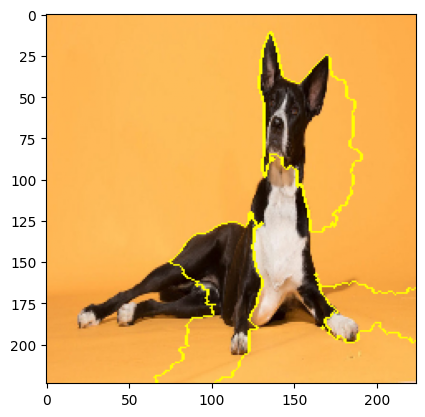

Task 4 (ResNet LIME Explanations): Passed (2 points)
Total Code Score: 6 / 6
Reflection Questions: 3 points (graded manually)


In [24]:
!mkdir datasets
!wget -p https://raw.githubusercontent.com/sprince0031/CS4445-AI-Practice/refs/heads/main/datasets/dog.jpg -O datasets/dog.jpg

# ================================
# Pytest Tests for Challenge #7: LIME Explainability
# ================================

import pytest
import numpy as np
import torch.nn as nn

def run_tests_and_accumulate_score():
    total_code_points = 6  # Tasks 1-4: 2 + 1 + 1 + 2 = 6 points
    score = 0

    def visualiseExplanation(explanation_image, mask):
        """Visualizes the LIME explanation with matplotlib."""
        plt.imshow(mark_boundaries(explanation_image, mask))
        plt.show()

    # Prepare dummy setup for testing:
    # Create a dummy image (224 x 224 x 3) as a numpy array.
    dummy_image = Image.open("datasets/dog.jpg")
    dummy_image = np.array(dummy_image)

    # Dummy model for LIME explanation tests (for Task 1, 2, 3)
    class DummyModel(nn.Module):
        def __init__(self):
            super(DummyModel, self).__init__()
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(224*224*3, 2)  # Assume 2 classes for simplicity.
        def forward(self, x):
            x = self.flatten(x)
            return torch.softmax(self.fc(x), dim=1)

    dummy_model = DummyModel()

    # ------------------------------
    # Task 1: get_lime_explanation (2 points)
    # ------------------------------
    try:
        explanation = get_lime_explanation(dummy_model, dummy_image, top_labels=2, num_samples=100)
        assert explanation is not None, "get_lime_explanation() returned None."
        # Check for at least one expected method (as_list or get_image_and_mask).
        has_method = hasattr(explanation, "as_list") or hasattr(explanation, "get_image_and_mask")
        assert has_method, "Explanation object lacks expected methods."
        score += 2
        print("Task 1 (get_lime_explanation): Passed (2 points)")
    except AssertionError as e:
        print("Task 1 (get_lime_explanation): Failed -", e)

    # ------------------------------
    # Task 2: display_lime_explanation (1 point)
    # ------------------------------
    try:
        expl_img, mask = display_lime_explanation(explanation, dummy_image, positive_only=True, num_features=5)
        assert expl_img is not None, "display_lime_explanation() returned None for explanation image."
        assert mask is not None, "display_lime_explanation() returned None for mask."
        assert isinstance(expl_img, np.ndarray), "Explanation image should be a numpy array."
        assert isinstance(mask, np.ndarray), "Mask should be a numpy array."
        score += 1
        print("Task 2 (display_lime_explanation): Passed (1 point)")
    except AssertionError as e:
        print("Task 2 (display_lime_explanation): Failed -", e)

    # ------------------------------
    # Task 3: extract_feature_importance (1 point)
    # ------------------------------
    try:
        feature_list = extract_feature_importance(explanation)
        assert isinstance(feature_list, list), "extract_feature_importance() should return a list."
        if feature_list:
            first_item = feature_list[0]
            assert isinstance(first_item, tuple) and len(first_item) == 2, "Each item should be a tuple (feature, importance)."
        score += 1
        print("Task 3 (extract_feature_importance): Passed (1 point)")
    except AssertionError as e:
        print("Task 3 (extract_feature_importance): Failed -", e)

    # ------------------------------
    # Task 4: Pretrained ResNet LIME Explanations (2 points)
    # ------------------------------
    try:
        explanations = get_resnet_lime_explanations(dummy_image)
        assert isinstance(explanations, dict), "get_resnet_lime_explanations() should return a dictionary."
        # Expect 5 keys corresponding to top 5 classes.
        assert len(explanations) == 5, "Expected explanations for top 5 classes."
        print('top 5 label predictions:')
        for i, (label, (expl_img, mask)) in enumerate(explanations.items()):
            assert isinstance(expl_img, np.ndarray), "Explanation image should be a numpy array."
            assert isinstance(mask, np.ndarray), "Mask should be a numpy array."
            print(f'{i+1}. {label}')
            # plt.subplot(1, 5, i+1)
        expl_img, mask = next(iter(explanations.values()))
        visualiseExplanation(expl_img, mask)
        score += 2
        print("Task 4 (ResNet LIME Explanations): Passed (2 points)")
    except AssertionError as e:
        print("Task 4 (ResNet LIME Explanations): Failed -", e)

    print(f"Total Code Score: {score} / {total_code_points}")

    # Reflection questions are graded manually.
    print("Reflection Questions: 3 points (graded manually)")

# Run the autograder.
run_tests_and_accumulate_score()